In [ ]:
'''This example demonstrates the use of Convolution1D for text classification.
Gets to 0.89 test accuracy after 2 epochs.
90s/epoch on Intel i5 2.4Ghz CPU.
10s/epoch on Tesla K40 GPU.
'''

from __future__ import print_function
import sys
sys.path.append('datasets')

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
import codeforces

# set parameters:
top_words = 20000
max_len = 1500
batch_size = 32
embed_dim = 32
filters = 128
kernel_size = 5
hidden_dims = 100
epochs = 20
dropout = 0.2

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=top_words)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(top_words+3, embed_dim, input_length=max_len))
model.add(Dropout(dropout))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(dropout))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

In [3]:
#评估模型好坏
#precision = TP / (TP + FP)
#recall = TP / (TP + FN)
#accuracy = (TP + TN) / (TP + FP + TN + FN)
#F1 Score = 2*P*R/(P+R)，其中P和R分别为 precision 和 recall
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
y_preds = np.round(model.predict(x_test))
result = precision_recall_fscore_support(y_test, y_preds, average='binary')
print(result)

(0.85117108732743907, 0.878, 0.86437741198708362, None)


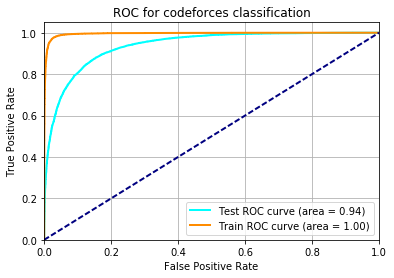

In [5]:
#ROC曲线和AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr={}
tpr={}
roc_auc={}

y_score1 = model.predict(x_test)
y_score2 = model.predict(x_train)

fpr['test'], tpr['test'], _ = roc_curve(y_test, y_score1)
roc_auc['test'] = auc(fpr['test'], tpr['test'])
fpr['train'], tpr['train'], _ = roc_curve(y_train, y_score2)
roc_auc['train'] = auc(fpr['train'], tpr['train'])
    
plt.figure()
lw = 2
plt.plot(fpr['test'], tpr['test'], color='aqua',
         lw=lw, label='Test ROC curve (area = %0.2f)' % roc_auc['test'])
plt.plot(fpr['train'], tpr['train'], color='darkorange',
         lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc['train'])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for codeforces classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()